In [18]:
# CLAIM: Many of the Prodigal-predicted ORFs are likely spurious. 

In [ ]:
import pandas as pd 
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import src.tools as tools
import glob
from src.files import FASTAFile, InterProScanFile
from src.reference import annotate
from scipy.stats import chisquare
from utils import * 

%load_ext autoreload 
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
get_percent = lambda n, total : f'{100 * n / total:.2f}%' if (total > 0) else '0%'
is_top_hit_hypothetical = lambda df : df.top_hit_product == 'hypothetical protein'

In [ ]:
dataset_df = pd.read_csv('../data/results/results-2/dataset.csv', index_col=0)
dataset_df = annotate(dataset_df)

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 
dataset_df = dataset_df[~dataset_df.genome_id.isin(exclude_genome_ids)].copy()

In [ ]:
# First, want to confirm that the predicted proteins are actually out-of-sample by aligning the sequences to the SwissProt database.

match_df = dataset_df[dataset_df.match].copy()
swissprot_df = pd.read_csv('../data/dataset/swissprot_bacteria.csv', index_col=0)

mmseqs = tools.MMSeqs()
match_align_df = mmseqs.align(match_df, subject_df=swissprot_df, query_name='match', subject_name='swissprot', output_dir='../data/results/results-2/', overwrite=False)
match_with_alignment_ids = match_align_df[match_align_df.bit_score > 50].query_id.unique()

In [8]:
is_aligned = lambda df : df.index.isin(match_with_alignment_ids)

print('Num. matches with a significant alignment:', is_aligned(match_df).sum(), f'({get_percent(is_aligned(match_df).sum(), len(match_df))})')
print('Num. hypothetical matches with a significant alignment:', (is_aligned(match_df) & is_top_hit_hypothetical(match_df)).sum(), f'({get_percent((is_aligned(match_df) & is_top_hit_hypothetical(match_df)).sum(), is_top_hit_hypothetical(match_df).sum())})')
print('Num. annotated matches with a significant alignment:', (is_aligned(match_df) & ~is_top_hit_hypothetical(match_df)).sum(), f'({get_percent((is_aligned(match_df) & ~is_top_hit_hypothetical(match_df)).sum(), (~is_top_hit_hypothetical(match_df)).sum())})')

Num. matches with a significant alignment: 31713 (64.17%)
Num. hypothetical matches with a significant alignment: 360 (4.58%)
Num. annotated matches with a significant alignment: 31353 (75.43%)


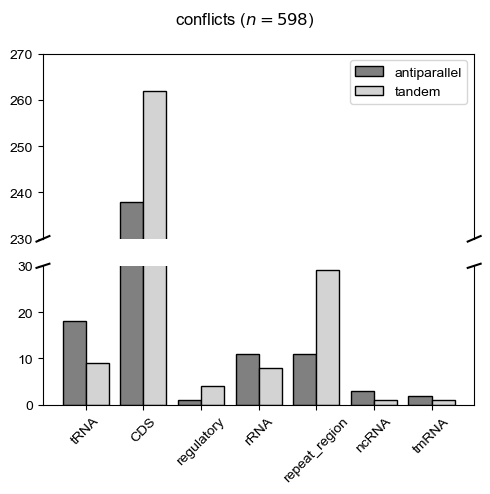

In [ ]:
def si_figure_2(dataset_df:pd.DataFrame, width:float=0.4):

    figure_df = dataset_df[dataset_df.conflict].copy()
    figure_df['top_hit_product'] = np.where(figure_df.top_hit_pseudo, 'pseudogene', figure_df.top_hit_product)
    figure_df['category'] = figure_df.top_hit_feature


    fig, axes = get_split_axes((0, 30), (230, 270))
    
    offsets = {True:width/2, False:-width/2}
    palette = {True:'lightgray', False:'gray'}
        
    positions = np.arange(figure_df.category.nunique())

    for same_strand, df in figure_df.groupby('same_strand'):
        ax_df = pd.DataFrame(index=figure_df.category.unique())
        ax_df['count'] = df.category.value_counts()
        axes[0].bar(positions + offsets[same_strand], ax_df['count'], color=palette[same_strand], edgecolor='black', width=width, label='tandem' if same_strand else 'antiparallel')
        axes[1].bar(positions + offsets[same_strand], ax_df['count'], color=palette[same_strand], edgecolor='black', width=width)

    axes[1].set_xticks(positions, labels=figure_df.category.unique(), rotation=45)
    axes[0].legend()

    # text = ''
    # for category, df in figure_df.groupby('category'):
    #     text += '$p_{' + category + '}$' + f' = {get_percent(len(df), len(figure_df))} ($n={len(df)}$)\n'
    # ax_a.text(0.4, 0.6, text, transform=ax_a.transAxes, fontsize='small')

    fig.suptitle(f'conflicts ($n={len(figure_df)}$)')
    fig.tight_layout()
    plt.show()

si_figure_2(dataset_df)

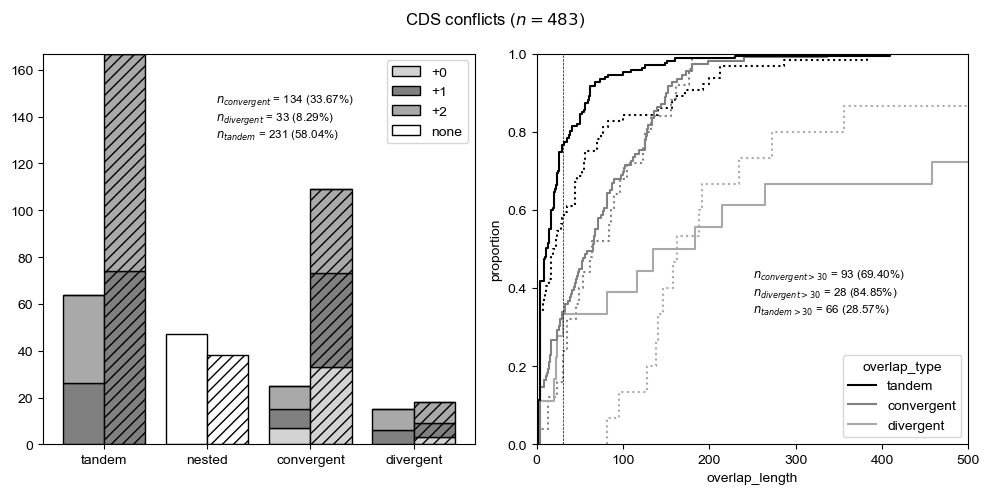

In [ ]:
# TODO: Not sure if it's worth including the phases in the bar plot. 

def si_figure_2(dataset_df:pd.DataFrame, exclude_nested:bool=False):
    figure_df = dataset_df[is_cds_conflict(dataset_df)].copy()
    # figure_df = figure_df[figure_df.overlap_type != 'nested'].copy() if exclude_nested else figure_df
    
    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

    figure_df['phase'] = ['none' if (row.overlap_type == 'nested') else '+' + str(int(row.phase)) for row in figure_df.itertuples()]

    palette = {'+0':'lightgray', '+1':'gray', '+2':'darkgray', 'none':'white'}
    overlap_types = figure_df.overlap_type.unique()
    positions = np.arange(len(overlap_types))
    width = 0.4

    def panel_a(ax_df:pd.DataFrame, offset:float=None, hatch=None, add_label:bool=True):
        totals =  np.zeros(len(overlap_types))
        bottom = np.zeros(len(overlap_types))
        for phase, df in ax_df.groupby('phase'):
            heights = [(df.overlap_type == overlap_type).sum() for overlap_type in overlap_types]
            ax_a.bar(positions + offset, heights, bottom=bottom, edgecolor='black', label=phase if add_label else None, color=palette[phase], width=width, hatch=hatch)
            bottom += np.array(heights)
            totals += heights

    panel_a(figure_df[is_top_hit_hypothetical(figure_df)], offset=-width/2)
    panel_a(figure_df[~is_top_hit_hypothetical(figure_df)], offset=width/2, hatch='///', add_label=False)
    
    text, total = '', len(figure_df) if (not exclude_nested) else ((figure_df.overlap_type != 'nested').sum())
    for overlap_type, df in figure_df.groupby('overlap_type'):
        if (overlap_type == 'nested') and exclude_nested:
            continue
        text += get_text(overlap_type, len(df), total)
    ax_a.text(0.4, 0.75, text, transform=ax_a.transAxes, fontsize='small')

    ax_a.set_xticks(positions, labels=overlap_types)
    ax_a.legend()

    ax_b_df = figure_df[figure_df.overlap_type != 'nested'].copy()
    palette = {'tandem':'black', 'convergent':'gray', 'divergent':'darkgray'}
    sns.ecdfplot(data=ax_b_df[is_top_hit_hypothetical(ax_b_df)], x='overlap_length', hue='overlap_type', ls=':', palette=palette, ax=ax_b)
    sns.ecdfplot(data=ax_b_df[~is_top_hit_hypothetical(ax_b_df)], x='overlap_length', hue='overlap_type', palette=palette, ax=ax_b)
    ax_b.set_xlim(xmin=0, xmax=500)
    ax_b.set_ylabel('proportion')

    overlap_length, text = 30, ''
    for overlap_type, df in ax_b_df.groupby('overlap_type'):
        text += get_text(f'{overlap_type} > {overlap_length}', (df.overlap_length > overlap_length).sum(), len(df))
    ax_b.text(0.5, 0.3, text, transform=ax_b.transAxes, fontsize='small')
    ax_b.axvline(x=overlap_length, ls='--', color='black', lw=0.5)

    fig.suptitle(f'CDS conflicts ($n={len(figure_df)}$)')
    fig.tight_layout()
    plt.show()

# si_figure_2(dataset_df, exclude_nested=True)
si_figure_2(dataset_df, exclude_nested=True)

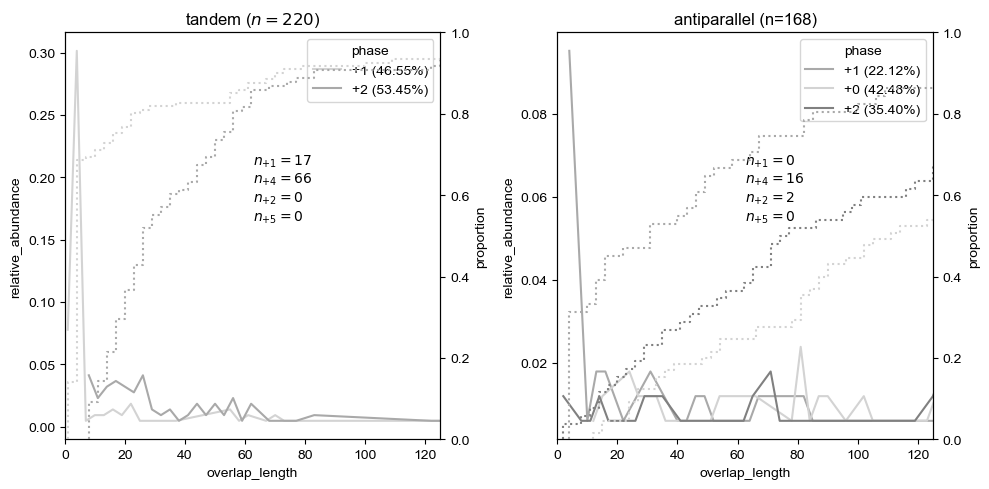

In [ ]:
# TODO: Should look at the query coverages for the overlaps with non-CDS features. 

figure_df = dataset_df[is_cds_conflict(dataset_df) & (dataset_df.overlap_type != 'nested')].copy()
figure_df['phase'] = figure_df.overlap_length % 3
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharey=False)

titles = {True:f'tandem ($n={figure_df.same_strand.sum()}$)', False:f'antiparallel ($n={(~figure_df.same_strand).sum()}$)'}

for ax, same_strand in zip(axes, [True, False]):
    ax_df = figure_df[figure_df.same_strand == same_strand].copy()
    ax_df = ax_df[ax_df.index != 'NZ_FAOO01000018.1_5'] # One of the tandem overlaps is +0 because the top hit is partial, and the query has a ton of X's in the middle.
    phase_counts = ax_df.phase.value_counts().to_dict()
    ax_df['phase'] = [f'+{phase} ({get_percent(phase_counts[phase], len(ax_df))})' for phase in ax_df.phase]

    palette = {label:['lightgray', 'darkgray', 'gray'][i] for i, label in enumerate(sorted(ax_df.phase.unique()))}
    ax_ = sns.ecdfplot(ax_df, x='overlap_length', hue='phase', palette=palette, ls=':', ax=ax.twinx(), legend=False)
    ax_.set_ylabel('proportion')

    ax_df = ax_df.overlap_length.value_counts().reset_index()
    ax_df['phase'] = ax_df.overlap_length % 3
    phase_counts = ax_df.phase.value_counts().to_dict()
    ax_df['phase'] = [f'+{phase} ({get_percent(phase_counts[phase], len(ax_df))})' for phase in ax_df.phase]
    ax_df['relative_abundance'] = ax_df['count'] / ax_df['count'].sum()
    
    palette = {label:['lightgray', 'darkgray', 'gray'][i] for i, label in enumerate(sorted(ax_df.phase.unique()))}
    sns.lineplot(ax_df, x='overlap_length', y='relative_abundance', hue='phase', palette=palette, ax=ax)

    text = ''
    for overlap_length in [1, 4, 2, 5]:
        n = ax_df[ax_df.overlap_length == overlap_length]['count']
        n = 0 if len(n) == 0 else n.iloc[0]
        text += '$n_{+' + str(overlap_length) + '} = ' + str(n) + '$\n'
    ax.text(0.5, 0.5, text, transform=ax.transAxes)
    ax.set_title(titles[same_strand])

    ax.set_xlim(xmin=0, xmax=125)

fig.tight_layout()



In [ ]:
def si_table(dataset_df:pd.DataFrame, normalize:bool=True):

    dataset_df = dataset_df[is_cds_conflict(dataset_df) & (dataset_df.overlap_type != 'nested')].copy()
    total = len(dataset_df)

    table_df = pd.DataFrame(index=pd.Series(['tandem', 'antiparallel'], name='direction'), columns=pd.Series([0, 1, 2], name='phase'))
    for same_strand, df in dataset_df.groupby('same_strand'):
        if same_strand:
            table_df.loc['tandem', :] = df.phase.value_counts()
        else:
            table_df.loc['antiparallel', :] = df.phase.value_counts()
    table_df = table_df.infer_objects(copy=False).fillna(0)
    if normalize:
        table_df = table_df / total

    return table_df

# Frequencies from https://pmc.ncbi.nlm.nih.gov/articles/PMC525685/. Study used 64,989 overlaps to generate this table. 
ref_table_df = pd.DataFrame([[0.001, 0.259, 0.578], [0.041, 0.062, 0.060]], index=pd.Series(['tandem', 'antiparallel'], name='direction'), columns=pd.Series([0, 1, 2], name='phase'))

# The incidence of tandem overlaps in the +1 frame is significantly higher than observed in nature. 
si_table_df = si_table(dataset_df, normalize=False, exclude_spurious=False)
observed_counts = si_table_df.loc['tandem', :]
expected_counts = ref_table_df.loc['tandem', :] / ref_table_df.loc['tandem', :].sum() * observed_counts.sum()
print(f'p={chisquare(observed_counts, expected_counts).pvalue}')

# # The distribution of phase frequencies of the real-predicted proteins matches that observed in confirmed overlaps.
# si_table_df = si_table(results_df, normalize=False, exclude_spurious=True)
# observed_counts = si_table_df.values.ravel()
# expected_counts = (ref_table_df.values.ravel() * observed_counts.sum())
# print(f'p={chisquare(observed_counts, expected_counts, sum_check=False).pvalue}')


In [ ]:
# # TODO: For how many of the tandem overlaps is the top hit to the left of the Prodigal prediction?
# # TODO: Check for any potential alternative start sites in the sequences, which will require grabbing the nucleotide sequences as well. 


# def si_figure_2(dataset_df:pd.DataFrame):

#     figure_df = dataset_df[is_cds_conflict(dataset_df)].copy()
#     figure_df = figure_df[~figure_df.top_hit_pseudo].copy()
    
#     fig, axes = plt.subplots(figsize=(15, 5), ncols=3)
#     overlap_types = ['divergent', 'convergent', 'tandem']

#     overlap_length = 100
#     query_overlap_fraction = 0.9

#     for overlap_type, ax in zip(overlap_types, axes):

#         sns.scatterplot(data=figure_df[figure_df.overlap_type == overlap_type], x='overlap_length', y='query_overlap_fraction', ax=ax, color='gray')
#         sns.scatterplot(data=figure_df[(figure_df.overlap_type == overlap_type) & (figure_df.index.isin(fixable_conflicts_df.index))], x='overlap_length', y='query_overlap_fraction', ax=ax, color='lightgray')
#         sns.scatterplot(data=figure_df[(figure_df.overlap_type == overlap_type) & (figure_df.n_hits > 1)], x='overlap_length', y='query_overlap_fraction', ax=ax, color='black')
        
#         ax.set_xscale('log')
#         ax.set_title(overlap_type)
#         ax.axvline(x=overlap_length, ls='--', lw=0.5, color='black')
#         ax.axhline(y=query_overlap_fraction, ls='--', lw=0.5, color='black')

#         x_max, y_max = ax.get_xlim()[1], ax.get_ylim()[1]
#         x = [overlap_length, x_max, x_max, overlap_length]
#         y = [query_overlap_fraction, query_overlap_fraction, y_max, y_max]
#         ax.fill(x, y, color='lightgray', alpha=0.5, zorder=-1)

#         ax.set_xlim(xmax=x_max)
#         ax.set_ylim(ymax=y_max)
    
#     fig.tight_layout()
#     plt.show()

# si_figure_2(dataset_df)

In [ ]:

    # nested_smorf_ids = figure_df[is_nested_orf(figure_df)].index

    # ax_b_df = figure_df[~figure_df.index.isin(nested_smorf_ids) & masks['cds']].copy()

    # total_same_strand, total_opposite_strand = ax_b_df.same_strand.sum(), (~ax_b_df.same_strand).sum()
    # categories = [f'same_strand (n={total_same_strand})', f'opposite_strand (n={total_opposite_strand})']
    # palette = {categories[0]:'lightgray', categories[1]:'gray'}
    # ax_b_df['category'] = np.select([ax_b_df.same_strand, ~ax_b_df.same_strand], categories, default='none')
    
    # sns.ecdfplot(ax=ax_b, data=ax_b_df[ax_b_df.top_hit_unsupported], x='overlap_length', hue='category', palette=palette, ls=':')
    # sns.ecdfplot(ax=ax_b, data=ax_b_df[~ax_b_df.top_hit_unsupported], x='overlap_length', hue='category', palette=palette)
    # ax_b.set_xlim(xmin=0, xmax=600)
    # ax_b.set_ylabel('proportion')
    # ax_b.set_xlabel('overlap length (bp)')
    # ax_b.set_title('CDS overlap')
    
    # overlap_length, text = 30, ''
    # for same_strand, df in ax_b_df.groupby('same_strand'):
    #     n = (df.overlap_length > overlap_length).sum()
    #     if same_strand:
    #         text += '$p_{sense >' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
    #     else:
    #         text += '$p_{antisense >' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
    # ax_b.text(0.5, 0.5, text, transform=ax_b.transAxes, fontsize='small')
    # ax_b.axvline(x=n, ls='--', color='black', lw=0.5)

    # sns.move_legend(ax_b, loc='lower right')


In [ ]:
# def table(results_df:pd.DataFrame):
#     conflicts_df = results_df[results_df.conflict].copy()
#     conflicts_df['top_hit_feature'] = np.where(conflicts_df.top_hit_feature.str.contains('RNA'), 'RNA', conflicts_df.top_hit_feature)

#     table_df = pd.DataFrame(index=conflicts_df.top_hit_feature.unique())
#     table_df['total'] = conflicts_df.top_hit_feature.value_counts().fillna(0)
#     table_df['real'] = conflicts_df[conflicts_df.model_label == 1].top_hit_feature.value_counts().fillna(0)
#     table_df['spurious'] = conflicts_df[conflicts_df.model_label == 0].top_hit_feature.value_counts().fillna(0)
#     table_df = table_df.fillna(0)

#     table_df['real'] = [f'{n} ({get_percent(n, total)})' for n, total in zip(table_df.real, table_df.total)]
#     table_df['spurious'] = [f'{n} ({get_percent(n, total)})' for n, total in zip(table_df.spurious, table_df.total)]

#     return table_df


# def table(results_df:pd.DataFrame):
#     results_df = results_df[results_df.conflict].copy()
#     results_df['category'] = np.where(results_df.same_strand, 'same_strand', 'opposite_strand')
    
#     table_df = pd.DataFrame(index=results_df.category.unique())
#     table_df['total'] = results_df.category.value_counts().fillna(0)
#     table_df['real'] = results_df[results_df.model_label == 1].category.value_counts().fillna(0)
#     table_df['spurious'] = results_df[results_df.model_label == 0].category.value_counts().fillna(0)
#     table_df = table_df.fillna(0)

#     table_df['real'] = [f'{n} ({get_percent(n, total)})' for n, total in zip(table_df.real, table_df.total)]
#     table_df['spurious'] = [f'{n} ({get_percent(n, total)})' for n, total in zip(table_df.spurious, table_df.total)]

#     return table_df

# table(results_df)

# df = results_df[(results_df.conflict) & (results_df.top_hit_feature == 'CDS')].copy()

# n_same_strand = df.same_strand.sum()
# n_opposite_strand = (~df.same_strand).sum()
# total = len(df)

# print('Num. conflicts on the same strand:', n_same_strand, f'({get_percent(n_same_strand, total)})')
# print(f'Num. conflicts on the opposite strand:', n_opposite_strand, f'({get_percent(n_opposite_strand, total)})')

# n_unsupported = df.top_hit_unsupported.sum()
# n_confirmed = (~df.top_hit_unsupported).sum()

# print('Num. conflicts with unsupported proteins:', n_unsupported, f'({get_percent(n_unsupported, total)})')
# print(f'Num. conflicts with confirmed proteins:', n_confirmed, f'({get_percent(n_confirmed, total)})')

# n_unsupported_same_strand = (df.same_strand & df.top_hit_unsupported).sum()
# n_unsupported_opposite_strand = (~df.same_strand & df.top_hit_unsupported).sum()
# total_unsupported = df.top_hit_unsupported.sum()

# print('Num. conflicts with unsupported proteins on the same strand:', n_unsupported_same_strand, f'({get_percent(n_unsupported_same_strand, total_unsupported)})')
# print(f'Num. conflicts with unsupported proteins on the opposite strand:', n_unsupported_opposite_strand, f'({get_percent(n_unsupported_opposite_strand, total_unsupported)})')

# n_spurious_same_strand = (df.same_strand & (df.model_label == 0)).sum()
# n_spurious_opposite_strand = ((~df.same_strand) & (df.model_label == 0)).sum()
# total_spurious = (df.model_label == 0).sum()

# print('Num. spurious conflicts on the same strand:', n_spurious_same_strand, f'({get_percent(n_spurious_same_strand, total_spurious)})')
# print(f'Num. spurious on the opposite strand:', n_spurious_opposite_strand, f'({get_percent(n_spurious_opposite_strand, total_spurious)})')

# n_spurious_unsupported = (df.top_hit_unsupported & (df.model_label == 0)).sum()
# n_spurious_confirmed = ((~df.top_hit_unsupported) & (df.model_label == 0)).sum()

# print('Num. spurious conflicts with unsupported proteins :', n_spurious_unsupported, f'({get_percent(n_spurious_unsupported, total_spurious)})')
# print(f'Num. spurious conflicts with confirmed proteins:', n_spurious_confirmed, f'({get_percent(n_spurious_confirmed, total_spurious)})')

In [ ]:
# # What do I want to analyze? 
# # Potential "false negatives," i.e. sequences with exact matches that are flagged as spurious. 
# # Potential "false positives," i.e. sequences with no matches that are flagged as real. 
# results_df['length'] = results_df.seq.apply(len)

# pseudogene_ids = pseudogenes_df.index.values
# intergenic_ids = results_df[results_df.top_hit_product == 'none'].index 

# fn_results_df = results_df[(results_df.model_label == 0) & (results_df.exact_match) & (~results_df.index.isin(pseudogene_ids))].copy()
# fp_results_df = results_df[(results_df.model_label == 1) & (~results_df.match) & (~results_df.index.isin(pseudogene_ids))].copy()
# tn_results_df = results_df[(results_df.model_label == 0) & (~results_df.match) & (~results_df.index.isin(pseudogene_ids))].copy()
# # fp_results_df = fp_results_df[(~fp_results_df.index.isin(intergenic_ids))].copy()

# table_df = pd.DataFrame(index=results_df.genome_id.unique())
# table_df['n_false_negatives'] = fn_results_df.value_counts('genome_id')
# table_df['n_false_positives'] = fp_results_df.value_counts('genome_id')
# table_df['n_true_negatives'] = tn_results_df.value_counts('genome_id')
# table_df['genome_size'] = dataset_df.groupby('genome_id').apply(len, include_groups=False)
# table_df['percent_false_negatives'] = [f'{p:.2f}%' for p in 100 * table_df.n_false_negatives / table_df.genome_size]
# table_df['percent_false_positives'] = [f'{p:.2f}%' for p in 100 * table_df.n_false_positives / table_df.genome_size]

# table_df


In [ ]:
# def correlation(x, y):
#     linreg = LinearRegression().fit(x.reshape(-1, 1), y) 
#     r2 = linreg.score(x.reshape(-1, 1), y)
#     return np.round(r2, 3), linreg


# def partial_correlation(x, y, z):
#     # Standardize the input arrays. 
#     x, y, z = (x - x.mean()) / x.std(), (y - y.mean()) / y.std(), (z - z.mean()) / z.std()

#     _, linreg_zy = correlation(z, y)
#     _, linreg_zx = correlation(z, x)
#     # Do not need to standardize the residuals (not sure if I completely understand why)
#     x_residuals = x - linreg_zx.predict(z.reshape(-1, 1))
#     y_residuals = y - linreg_zy.predict(z.reshape(-1, 1))

#     r2, linreg_xy = correlation(x_residuals, y_residuals)
#     return r2, linreg_xy, (x_residuals, y_residuals)

In [ ]:
# def figure(dataset_df:pd.DataFrame, level:str='genus', top_n:int=5):

#     fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

#     for ax, (_, df) in zip(axes, dataset_df.groupby('label')):
#         ax_df = df.value_counts(level)
#         ax_df = ax_df / ax_df.sum() * 100
#         ax_df = ax_df[ax_df.index != 'none'].copy()
#         ax_df = ax_df.iloc[:top_n]

#         sns.barplot(data=ax_df, ax=ax, color='lightgray', edgecolor='black')

#         if (level == 'species'):
#             x_tick_labels = [f'{taxon.split()[0][0]}. {taxon.split()[-1]}' for taxon in ax_df.index]
#             ax.set_xticks(np.arange(len(ax_df)), labels=x_tick_labels, rotation=90, fontstyle='italic')
#         else:
#             ax.set_xticks(np.arange(len(ax_df)), labels=ax_df.index, rotation=90)
#         ax.yaxis.set_major_formatter(tick.PercentFormatter())
#         ax.text(0.5, 0.7, f'{ax_df.sum():.2f}% in top {top_n} {level}', transform=ax.transAxes)

#     axes[0].set_title('AntiFam')
#     axes[1].set_title('SwissProt')

#     fig.tight_layout()
#     plt.show()

# figure(dataset_df, level='phylum')

In [ ]:
# def sample_by_length(df:pd.DataFrame, ref_ids:list=None, ids:list=None, n_bins:int=5):

#     assert 'length' in df.columns, 'sample_by_length: Input DataFrame must have a length column.'
#     ref_lengths = df.loc[ref_ids].length
#     lengths = df.loc[ids].length

#     ref_counts, ref_bins = np.histogram(ref_lengths, n_bins)

#     p = ref_counts / ref_counts.sum() # The probability of a random reference sequence belonging to each bin.
#     n = len(ids)
#     bin_labels = pd.cut(lengths, ref_bins, labels=False) # Bin the lengths according to the reference bin edges. 
#     counts = (p * n).astype(int)

#     sample_ids = list()
#     for bin_label, count in enumerate(counts):
#         bin_mask = bin_labels == bin_label
#         bin_ids = bin_labels[bin_mask].index
#         bin_n = bin_mask.sum()
#         sample_ids += list(np.random.choice(bin_ids, min(count, bin_n), replace=False))

#     print('sample_by_length: Reference size:', len(ref_ids))
#     print('sample_by_length: Sample size:', len(sample_ids))

#     return np.array(sample_ids)

In [ ]:
# def filter_blast(blast_df:pd.DataFrame): # , min_bit_score:float=0):
#     mask = (blast_df.bit_score / blast_df.alignment_length) >= 1
#     # blast_df = blast_df[blast_df.bit_score > min_bit_score].copy()
#     print(f'filter_blast: Removing {(~mask).sum()} insignificant alignments.')
#     blast_df = blast_df[mask].copy()

#     mask = blast_df.duplicated(subset=['query_id', 'subject_id'], keep='first')
#     print(f'filter_blast: Removing {mask.sum()} duplicate alignments.')
#     blast_df = blast_df[~mask].copy()

#     blast_df = blast_df.sort_values(['query_id', 'bit_score'], ascending=False)
#     return blast_df

In [ ]:

# np.quantile(pseudogenes_with_reference_df.alignment_length_no_gaps, [0.25, 0.5, 0.75])

# columns = ['25% <', '50% <', '75% <']
# index = ['sequence_identity', 'alignment_length', 'query_coverage', 'subject_coverage']
# table_df = pd.DataFrame(index=index, columns=columns)
# table_df.loc['sequence_identity', :] = 100 * np.quantile(pseudogenes_with_reference_df.sequence_identity, [0.25, 0.5, 0.75])
# table_df.loc['alignment_length', :] = np.quantile(pseudogenes_with_reference_df.alignment_length, [0.25, 0.5, 0.75]).astype(int)
# table_df.loc['query_coverage', :] = 100 * np.quantile(pseudogenes_with_reference_df.query_coverage, [0.25, 0.5, 0.75])
# table_df.loc['subject_coverage', :] = 100 * np.quantile(pseudogenes_with_reference_df.subject_coverage, [0.25, 0.5, 0.75])

# table_df

In [ ]:
# # def figure():
# fig, ax = plt.subplots(figsize=(5, 5))

# ax_df = pseudogenes_align_df.copy()
# ax_df['model_output_1'] = pseudogenes_df.model_output_1
# ax_df['model_label'] = pseudogenes_df.model_label
# ax_df['length'] = ax_df.query_seq.apply(len)
# ax_df['has_weak_homology'] = ~ax_df.index.isin(pseudogenes_with_significant_homology)
# ax_df['has_significant_interpro_hit'] = ~ax_df.index.isin(pseudogenes_with_significant_interpro_hit)
# ax_df['has_significant_alignment'] = ax_df.bit_score > 50

# print(f'figure: Displaying {len(ax_df)} out of {len(pseudogenes_df)} total translated pseudogenes.')
# print(f'figure: Displaying {(ax_df.model_label == 0).sum()} out of {(pseudogenes_df.model_label == 0).sum()} of the translated pseudogenes classified as spurious.')

# ax_df = ax_df.sort_values('model_output_1', ascending=False)
# palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['indianred', 'lightgray', 'darkseagreen'])
# ax = sns.scatterplot(data=ax_df, x='fraction_identical_matches', y='alignment_length', ax=ax, hue='model_output_1', palette=palette, size=ax_df.length)
# ax = sns.scatterplot(data=ax_df[ax_df.has_weak_homology], x='fraction_identical_matches', y='alignment_length', ax=ax, color='none', edgecolor='black', size=ax_df.length)
# # ax = sns.scatterplot(data=ax_df[ax_df.has_significant_alignment], x='fraction_identical_matches', y='alignment_length', ax=ax, color='none', edgecolor='black')
# handles, labels = list(), list()
# for handle, label in zip(*ax.get_legend_handles_labels()):
#     if re.match(r'^\d*\.\d+$', label):
#         handles.append(handle)
#         labels.append(label)
# ax.legend(handles, labels, title='model output')

# ax.set_yscale('log')
# fig.tight_layout()
# plt.show()

In [ ]:
# def figure(matches_df:pd.DataFrame):

#     fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)

#     # Want to take a look at the sequences which are in-frame, but have the wrong start codon. 
#     ax_df = matches_df[matches_df.match & (~matches_df.exact_match)].copy()
#     ax_df['length_diff_fraction'] = ax_df.length_diff / ax_df.top_hit_length
#     ax_df = ax_df[ax_df.length_diff > 0].copy()
#     ax_df = ax_df.sort_values('model_output_1', ascending=False)

#     palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['indianred', 'lightgray', 'darkseagreen'])
#     ax_a = sns.scatterplot(ax_df[ax_df.truncated], x='length', y='length_diff_fraction', ax=ax_a, hue='model_output_1', palette=palette)
#     ax_b = sns.scatterplot(ax_df[ax_df.extended], x='length', y='length_diff_fraction', ax=ax_b, hue='model_output_1', palette=palette)
#     # palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['firebrick', 'gray', 'seagreen'])
#     # ax_b = sns.scatterplot(ax_df[(ax_df.extended) & (ax_df.top_hit_length < 100)], x='length', y='length_diff_fraction', ax=ax_b, palette=palette, hue='model_output_1', legend=None)

#     n_real, n_spurious = (ax_df[ax_df.truncated].model_label == 1).sum(), (ax_df[ax_df.truncated].model_label == 0).sum()
#     ax_a.text(0.6, 0.5, f'n_spurious = {n_spurious}\nn_real = {n_real}', transform=ax_a.transAxes, ha='left')
    
#     ax_b.axvline(x=200, ls='--', ymin=0, ymax=ax_b.get_ylim()[-1], color='black', lw=0.5)
#     ax_b.axvline(x=300, ls='--', ymin=0, ymax=ax_b.get_ylim()[-1], color='black', lw=0.5)

#     n_real, n_spurious = (ax_df[ax_df.extended].model_label == 1).sum(), (ax_df[ax_df.extended].model_label == 0).sum()
#     ax_b.text(0.6, 0.5, f'n_spurious = {n_spurious}\nn_real = {n_real}', transform=ax_b.transAxes, ha='left')

#     ax_a.set_title('truncations')
#     ax_b.set_title('extensions')
#     ax_b.set_xlabel('length')

#     sns.move_legend(ax_b, loc='upper right')
#     sns.move_legend(ax_a, loc='upper right')
#     ax_b.set_xscale('log')
#     # ax_b.set_yscale('log', base=2)
#     ax_b.set_ylim(ymax=2.2)
#     ax_a.set_xscale('log')

#     plt.show()

# figure(matches_df)

# # Are there any cases where the long extensions read into a downstream protein that is in-frame?


In [ ]:

# def figure(dataset_df:pd.DataFrame):

#     fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)

#     dataset_df = dataset_df.copy()
#     # Want to take a look at the sequences which are in-frame, but have the wrong start codon. 
#     ax_df = dataset_df[dataset_df.match & (~dataset_df.exact_match)].copy()
#     ax_df['gc_percent'] = dataset_df.query_gc_content
#     ax_df['truncated'] = ax_df.top_hit_length > ax_df.length
#     ax_df['extended'] = ax_df.top_hit_length < ax_df.length
#     ax_df['length_diff'] = np.abs(ax_df.top_hit_seq.apply(len) - ax_df.seq.apply(len))
#     ax_df['length_diff_fraction'] = ax_df.length_diff / ax_df.top_hit_length
#     ax_df = ax_df[ax_df.length_diff > 0].copy()
#     ax_df = ax_df.sort_values('length_diff_fraction', ascending=True)

#     # assert np.all(df.overlap_length == df.top_hit_length)
#     print('figure: Number of extended matches:', ax_df.extended.sum())
#     print('figure: Number of truncated matches:', ax_df.truncated.sum())

#     palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['white', 'gray'])
#     ax_a = sns.scatterplot(ax_df[ax_df.truncated], x='top_hit_length', y='gc_percent', ax=ax_a, hue='length_diff_fraction', palette=palette)
    
#     palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['white', 'gray'])
#     ax_b = sns.scatterplot(ax_df[ax_df.extended], x='top_hit_length', y='gc_percent', ax=ax_b, hue='length_diff_fraction', palette=palette)

#     sns.move_legend(ax_b, loc='lower right')
#     sns.move_legend(ax_a, loc='lower right')
#     ax_b.set_xscale('log')
#     ax_a.set_xscale('log')

#     plt.show()

# figure(dataset_df)

In [ ]:
# df = dataset_df[dataset_df.conflict].copy()
# df['top_hit_feature'] = np.where(df.top_hit_feature.str.contains('RNA'), 'RNA', df.top_hit_feature)

# fig, ax = plt.subplots()

# ax_df = pd.DataFrame(columns=['same_strand', 'opposite_strand'], index=df.top_hit_feature.unique(), dtype=int)
# for feature, df_ in df.groupby('top_hit_feature'):
#     ax_df.loc[feature, 'same_strand'] = df_.same_strand.sum()
#     ax_df.loc[feature, 'opposite_strand'] = (~df_.same_strand).sum()
# annot = ax_df.values.astype(int).astype(str)
# ax_df = ax_df / ax_df.sum(axis=1).values.reshape(-1, 1)

# sns.heatmap(ax_df, annot=annot, vmin=0, vmax=1, fmt='', edgecolor='black', cbar=False, ax=ax, linecolor='black', linewidths=0.5, cmap='Grays')

# for spine in ax.spines.values():
#     spine.set_visible(True)
#     spine.set_edgecolor('black')
#     spine.set_linewidth(0.5)

In [ ]:
# df = results_df[(results_df.match) & (results_df.model_label == 0)].copy()
# df['unsupported'] = df.top_hit_unsupported
# df['hypothetical'] = ~df.top_hit_unsupported & (df.top_hit_product == 'hypothetical protein')
# df['annotated'] = ~df.top_hit_unsupported & (df.top_hit_product != 'hypothetical protein')
# df['category'] = np.select([df.unsupported, df.hypothetical, df.annotated], ['unsupported', 'hypothetical', 'annotated'], default='none')

# n_hypothetical = df.hypothetical.sum()
# n_annotated = df.annotated.sum()
# n_unsupported = df.unsupported.sum()
# n_smorfs = (df.length < 100).sum()

# print(f'Number of hypothetical proteins: {n_hypothetical} ({get_percent(n_hypothetical, len(df))})')
# print(f'Number of unsupported proteins: {n_unsupported} ({get_percent(n_unsupported, len(df))})')
# print(f'Number of annotated proteins: {n_annotated} ({get_percent(n_annotated, len(df))})')
# print(f'Number of smORFs: {n_smorfs} ({get_percent(n_smorfs, len(df))})')

# fig, ax = plt.subplots()

# text = ''
# for category in df.category.unique():
#     lengths = df[df.category == category].length
#     n = (lengths < 100).sum()
#     p = get_percent(n, len(lengths))
#     text += '$n_{' + category + ' < 100}$ = ' + f'{n} ({p})\n'
# ax.text(0.5, 0.5, text, transform=ax.transAxes)

# palette = {'annotated':'darkseagreen', 'unsupported':'indianred', 'hypothetical':'steelblue'}
# sns.ecdfplot(df, x='length', hue='category', ax=ax, palette=palette)
# ax.set_ylabel('proportion')
# plt.show()


In [ ]:
# fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

# palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['white', 'indianred'])

# df_ = df[df.model_label == 0].copy()
# ax_df = pd.DataFrame(0, index=['same_strand', 'opposite_strand'], columns=['confirmed', 'unsupported'])
# ax_df.loc['same_strand', 'confirmed'] = (df_.same_strand & (~df_.top_hit_unsupported)).sum()
# ax_df.loc['opposite_strand', 'confirmed'] = ((~df_.same_strand) & (~df_.top_hit_unsupported)).sum()
# ax_df.loc['same_strand', 'unsupported'] = (df_.same_strand & df_.top_hit_unsupported).sum()
# ax_df.loc['opposite_strand', 'unsupported'] = ((~df_.same_strand) & df_.top_hit_unsupported).sum()
# sns.heatmap(ax_df, annot=True, cbar=False, ax=ax_a, cmap=palette, fmt='d')

# palette = mpl.colors.LinearSegmentedColormap.from_list('palette', ['white', 'darkseagreen'])

# df_ = df[df.model_label == 1].copy()
# # df_ = df[df.model_output_1 > 0.95].copy()
# ax_df = pd.DataFrame(0, index=['same_strand', 'opposite_strand'], columns=['confirmed', 'unsupported'])
# ax_df.loc['same_strand', 'confirmed'] = (df_.same_strand & (~df_.top_hit_unsupported)).sum()
# ax_df.loc['opposite_strand', 'confirmed'] = ((~df_.same_strand) & (~df_.top_hit_unsupported)).sum()
# ax_df.loc['same_strand', 'unsupported'] = (df_.same_strand & df_.top_hit_unsupported).sum()
# ax_df.loc['opposite_strand', 'unsupported'] = ((~df_.same_strand) & df_.top_hit_unsupported).sum()
# sns.heatmap(ax_df, annot=True, cbar=False, ax=ax_b, cmap=palette)




In [ ]:
# def get_all_hits_overlap_info(row, all_hits_df:pd.DataFrame=all_hits_df):

#     info = {'id':row.Index}
#     if row.n_hits < 2:
#         info['all_hits_overlap_length'] = row.overlap_length 
#         info['all_hits_overlap_min_start'] = row.overlap_start
#         info['all_hits_overlap_max_stop'] = row.overlap_stop
#         return info
    
#     all_hits_df = all_hits_df[all_hits_df.query_id == row.Index]
#     all_hits_df = all_hits_df.sort_values('overlap_start')
#     # top_hit_overlap_length = all_hits_df.sort_values('overlap_length', ascending=False).iloc[0].overlap_length
#     # query_length = all_hits_df.iloc[0].query_stop - all_hits_df.iloc[0].query_start + 1
    
#     idxs = list()
#     curr_overlap_start, curr_overlap_stop = all_hits_df.iloc[0].overlap_start, all_hits_df.iloc[0].overlap_stop
#     for row in all_hits_df.iloc[1:].itertuples():
#         if row.overlap_start <= curr_overlap_stop:
#             curr_overlap_stop = row.overlap_stop 
#         else:
#             idxs.append((curr_overlap_start, curr_overlap_stop))
#             curr_overlap_start, curr_overlap_stop = row.overlap_start, row.overlap_stop 
#     idxs.append((curr_overlap_start, curr_overlap_stop))

#     info['all_hits_overlap_length'] = sum([overlap_stop - overlap_start for overlap_start, overlap_stop in idxs])
#     info['all_hits_overlap_min_start'] = min([overlap_start for overlap_start, _ in idxs])
#     info['all_hits_overlap_max_stop'] = max([overlap_stop for _, overlap_stop in idxs])
#     return info

# if 'all_hits_overlap_length' not in dataset_df.columns:
#     all_hits_overlap_df = pd.DataFrame([get_all_hits_overlap_info(row) for row in dataset_df.itertuples()]).set_index('id')
#     dataset_df = all_hits_overlap_df.merge(dataset_df, left_index=True, right_index=True) 
#     dataset_df['overlap_at_both_query_termini'] = (dataset_df.all_hits_overlap_min_start == dataset_df.query_start) & (dataset_df.all_hits_overlap_max_stop == dataset_df.query_stop)

# print('Num. conflicts with overlap at both query termini:', (dataset_df.overlap_at_both_query_termini & dataset_df.conflict).sum())
# print('Num. non-nested conflicts with overlap at both query termini:', (dataset_df.overlap_at_both_query_termini & (dataset_df.overlap_type != 'nested') & df.conflict).sum())
# print('Num. non-nested conflicts with multiple overlaps:', ((dataset_df.n_hits > 1) & (dataset_df.overlap_type != 'nested') & df.conflict).sum())

In [ ]:
# Maybe worth characterizing the secondary overlaps too... 
# def si_figure_2(dataset_df:pd.DataFrame, all_hits_df:pd.DataFrame):

#     totals = dataset_df[is_cds_conflict(dataset_df)].overlap_type.value_counts()
#     ids = dataset_df[(dataset_df.n_hits > 1) & is_cds_conflict(dataset_df)].index.values

#     fig, (ax_a, ax_b) = plt.subplots(figsize=(10, 5), ncols=2)
#     overlap_types = ['divergent', 'convergent', 'tandem', 'nested']

#     positions = np.arange(len(overlap_types))

#     figure_df = list()
#     for id_ in ids:
#         row = {'id':id_}
#         df = all_hits_df[all_hits_df.query_id == id_].sort_values('overlap_length', ascending=False)
#         row['primary_overlap_type'] = df.iloc[0].overlap_type 
#         row['secondary_overlap_type'] = df.iloc[1].overlap_type 
#         row['secondary_overlap_length'] = df.iloc[1].overlap_length 
#         row['secondary_overlap_uncertain'] = (df.iloc[0].subject_evidence_type == 'ab initio prediction') and (df.iloc[0].subject_product == 'hypothetical protein')
#         figure_df.append(row)
#     figure_df = pd.DataFrame(figure_df).set_index('id')

#     ax_a_df = figure_df.groupby('primary_overlap_type').secondary_overlap_type.value_counts()
#     ax_a_df = ax_a_df.reset_index().pivot(columns='primary_overlap_type', index='secondary_overlap_type', values='count').fillna(0)
#     ax_a_df = ax_a_df.loc[['tandem', 'convergent', 'divergent', 'nested']]
    
#     bottom = np.zeros(len(ax_a_df))
#     positions = np.arange(len(ax_a_df))
#     palette = {'tandem':'black', 'convergent':'gray', 'divergent':'lightgray', 'nested':'white'}
#     for overlap_type in ax_a_df.index:
#         heights = ax_a_df.loc[overlap_type].values
#         ax_a.bar(positions, heights, bottom=bottom, color=palette[overlap_type], edgecolor='black', label=overlap_type, hatch='///' if (overlap_type == 'nested') else None)
#         bottom += heights
#     ax_a.set_xticks(positions, labels=ax_a_df.columns)
#     ax_a.legend()
#     ax_a.set_xlabel('primary_overlap_type')

#     ax_b_df = figure_df[figure_df.secondary_overlap_type != 'nested'].copy()
#     # sns.ecdfplot(data=ax_b_df[ax_b_df.secondary_overlap_uncertain], x='secondary_overlap_length', hue='secondary_overlap_type', ax=ax_b, ls=':')
#     sns.ecdfplot(data=ax_b_df, x='secondary_overlap_length', hue='secondary_overlap_type', ax=ax_b, palette=palette)
#     ax_b.set_ylabel('proportion')

#     overlap_length, text = 30, ''
#     for overlap_type, df in ax_b_df.groupby('secondary_overlap_type'):
#         n = (df.secondary_overlap_length > overlap_length).sum()
#         text += '$p_{' + overlap_type + '>' + str(overlap_length) + '}$' + f' = {get_percent(n, len(df))} ($n={n}$)\n'
#     ax_b.text(0.5, 0.3, text, transform=ax_b.transAxes, fontsize='small')
#     ax_b.axvline(x=overlap_length, ls='--', color='black', lw=0.5)

#     fig.suptitle(f'secondary overlaps ($n={len(figure_df)}$)')
#     fig.tight_layout()
#     plt.show()

# si_figure_2(dataset_df, all_hits_df)